**This notebook accompanies the sbs step of the pipeline.**

In [87]:
import ops
from ops.imports_ipython import *
import ops.firesnake
from ops.firesnake import Snake
from ops.qc import *
import seaborn as sns
from glob import glob
from microfilm import microplot
from microfilm.microplot import Micropanel
import matplotlib.pyplot as plt

# %matplotlib widget

from microfilm.microanim import Microanim

# Set screen directories
sbs_function_home = "/lab/barcheese01/screens"
sbs_function_dataset = "baker"

# Set home directory as a combination of parse_function_home and parse_function_dataset
home = os.path.join(sbs_function_home, sbs_function_dataset)

### Run sbs snakemake pipeline on one well / tile combination

In [2]:
# Define lists of cycles
SBS_CYCLES = [1, 2, 3, 4, 5, 6, 7, 8, 9]

# A string representing bases
BASES = 'GTAC' 

# Define threshold values
THRESHOLD_READS = 315  # Threshold for detecting reads
THRESHOLD_DAPI = 1200  # Threshold for segmenting nuclei based on dapi signal
THRESHOLD_CELL = 500  # Threshold for segmenting cells on sbs background signal, specific to well 'A1'
NUCLEUS_AREA = (0.25 * 150, 0.25 * 800)  # Tuple representing nucleus area
Q_MIN = 0  # Minimum Levenshtein distance

# Set wildcards (one well / tile combination to test on)
WELLS = 'A1'  # List of well identifiers
TILES = 50  # List of tile numbers + 1
WILDCARDS = dict(well=WELLS, tile=TILES)

# Read data from a CSV file named 'barcodes.csv' and store it in a DataFrame
df_pool = pd.read_csv(os.path.join(home, 'sbs_1/barcodes.csv'), index_col=None)
barcodes = df_pool['sgRNA'].str[:9]

# Define display ranges for different channels, recognized by ImageJ
DISPLAY_RANGES = [
    [500, 15000],  # Range for DAPI channel
    [100, 10000],  # Range for CY3 channel
    [100, 10000],  # Range for A594 channel
    [200, 25000],  # Range for CY5 channel
    [200, 25000]   # Range for CY7 channel
]

# Define LUTs (Lookup Tables) for different channels
LUTS = [
    ops.io.GRAY,    # Lookup table for DAPI channel
    ops.io.GREEN,   # Lookup table for CY3 channel
    ops.io.RED,     # Lookup table for A594 channel
    ops.io.MAGENTA, # Lookup table for CY5 channel
    ops.io.CYAN     # Lookup table for CY7 channel
]

In [3]:
# Define the search pattern relative to the home directory
search_pattern = 'input_sbs/process/input/10X/multidimensional/10X*{well}_Tile-{tile}.sbs.tif'.format(**WILDCARDS)
search_path = os.path.join(home, search_pattern)

# Use glob.glob to find files matching the search pattern
input_files = natsorted(glob(search_path))

# Print the found files
for f in input_files:
    print(f)

# manually change saving directory to sbs_1 directory
description = parse(input_files[0])
description['subdir'] = os.path.join(home, 'sbs_1')
description.pop('cycle');
description

/lab/barcheese01/screens/baker/input_sbs/process/input/10X/multidimensional/10X_c1-SBS-1_A1_Tile-50.sbs.tif
/lab/barcheese01/screens/baker/input_sbs/process/input/10X/multidimensional/10X_c2-SBS-2_A1_Tile-50.sbs.tif
/lab/barcheese01/screens/baker/input_sbs/process/input/10X/multidimensional/10X_c3-SBS-3_A1_Tile-50.sbs.tif
/lab/barcheese01/screens/baker/input_sbs/process/input/10X/multidimensional/10X_c4-SBS-4_A1_Tile-50.sbs.tif
/lab/barcheese01/screens/baker/input_sbs/process/input/10X/multidimensional/10X_c5-SBS-5_A1_Tile-50.sbs.tif
/lab/barcheese01/screens/baker/input_sbs/process/input/10X/multidimensional/10X_c6-SBS-6_A1_Tile-50.sbs.tif
/lab/barcheese01/screens/baker/input_sbs/process/input/10X/multidimensional/10X_c7-SBS-7_A1_Tile-50.sbs.tif
/lab/barcheese01/screens/baker/input_sbs/process/input/10X/multidimensional/10X_c8-SBS-8_A1_Tile-50.sbs.tif
/lab/barcheese01/screens/baker/input_sbs/process/input/10X/multidimensional/10X_c9-SBS-9_A1_Tile-50.sbs.tif


{'subdir': '/lab/barcheese01/screens/baker/sbs_1',
 'mag': '10X',
 'well': 'A1',
 'tile': '50',
 'tag': 'sbs',
 'ext': 'tif',
 'file': '/lab/barcheese01/screens/baker/input_sbs/process/input/10X/multidimensional/10X_c1-SBS-1_A1_Tile-50.sbs.tif'}

##### load, align, apply Laplacian-of-Gaussian filter (log)

In [4]:
data = np.array([read(f) for f in input_files])
# save(name(description, tag='original'), data)
print(data.shape) # expected dimensions of (CYCLE, CHANNEL, I, J)
# aligns SBS data using the 'SBS_mean' method
aligned = Snake._align_SBS(data, method='SBS_mean')
# save(name(description, tag='aligned'), aligned, display_ranges=DISPLAY_RANGES, luts=LUTS) # play around with display ranges

(9, 5, 1480, 1480)


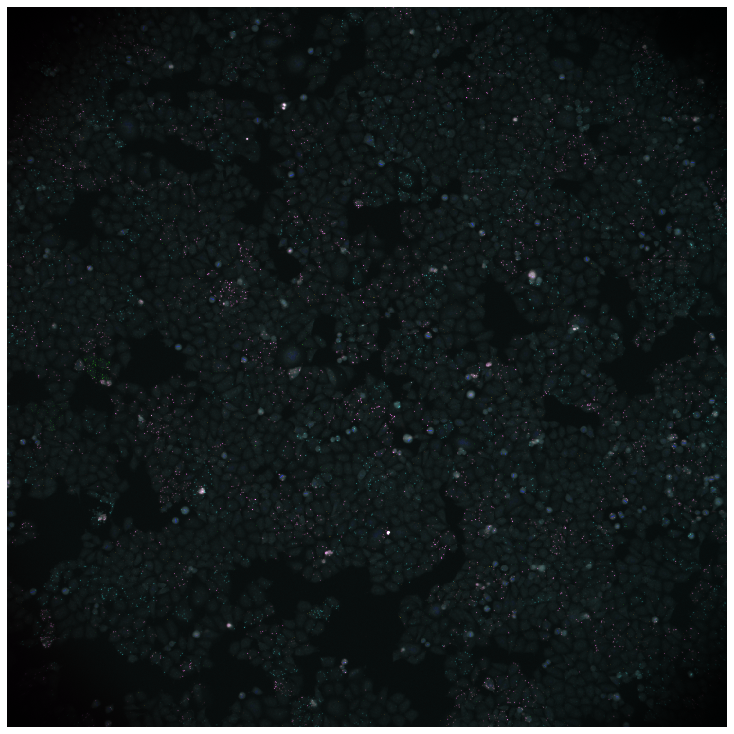

In [5]:
aligned_transposed = np.transpose(aligned, (1, 0, 2, 3))
anim = Microanim(data=aligned_transposed, fig_scaling=10, cmaps = ['pure_blue', 'pure_green', 'pure_yellow', 'pure_magenta', 'pure_cyan'])
anim.ui

In [6]:
# transforms aligned data skipping dapi (0)
loged = Snake._transform_log(aligned, skip_index=0)
print(loged.shape)
# save(name(description, tag='log'), loged, display_ranges=DISPLAY_RANGES, luts=LUTS)

(9, 5, 1480, 1480)


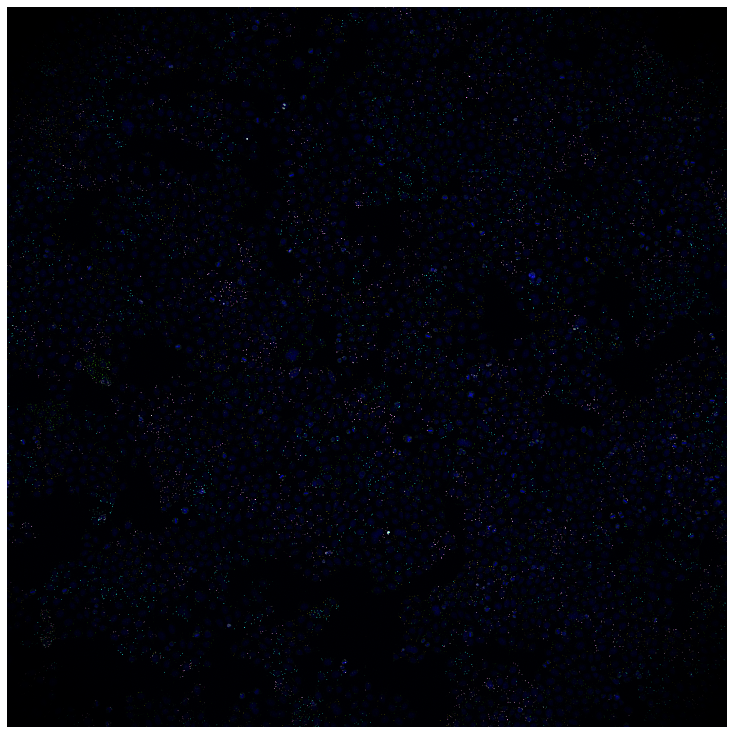

In [7]:
loged_transposed = np.transpose(loged, (1, 0, 2, 3))
anim = Microanim(data=loged_transposed, fig_scaling=10, cmaps = ['pure_blue', 'pure_green', 'pure_yellow', 'pure_magenta', 'pure_cyan'])
anim.ui

##### detect candidate reads

In [8]:
# computes standard deviation skipping dapi (0)
std = Snake._compute_std(loged, remove_index=0)
print(std.shape)
# save(name(description, tag='std'), std)

(1480, 1480)


In [9]:
# finds peaks
peaks = Snake._find_peaks(std)
print(peaks.shape)
# save(name(description, tag='peaks'), peaks)

(1480, 1480)


In [10]:
# apply a maximum filter with a given width (3) skipping dapi (0)
maxed = Snake._max_filter(loged, 3, remove_index=0)
print(maxed.shape)
# save(name(description, tag='maxed'), maxed, display_ranges=DISPLAY_RANGES[1:], luts=LUTS[1:])

(9, 4, 1480, 1480)


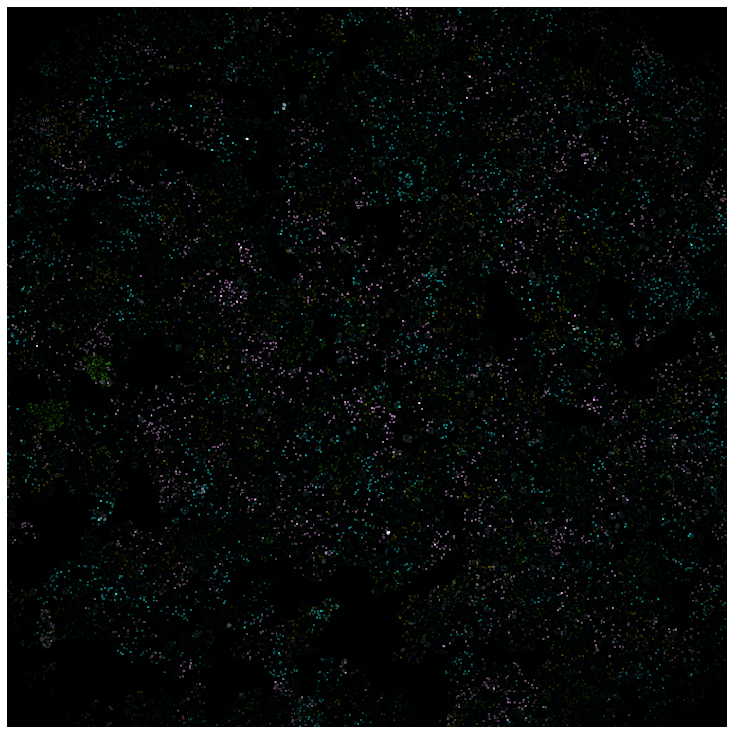

In [11]:
maxed_transposed = np.transpose(maxed, (1, 0, 2, 3))
anim = Microanim(data=maxed_transposed, fig_scaling=10, cmaps = ['pure_green', 'pure_yellow', 'pure_magenta', 'pure_cyan'])
anim.ui

##### segment nuclei and cells

In [12]:
# segment nuclei using dapi channel, dapi intensity and nucleus area thresholds
nuclei = Snake._segment_nuclei(data[0], THRESHOLD_DAPI, area_min=NUCLEUS_AREA[0], area_max=NUCLEUS_AREA[1])
# save(name(description, tag='nuclei'), nuclei, compress=1)

Number of nuclei segmented: 3435


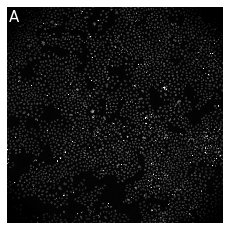

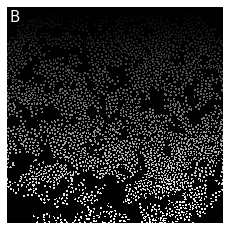

In [57]:
# Create microshow plots for each channel with specified colormaps and display ranges
dapi_microshow = microplot.microshow(data[0, 0, :, :],
                                     rescale_type='limits', 
                                     limits=DISPLAY_RANGES[0],
                                     label_text='A', 
                                     channel_names='Dapi')

nuclei_microshow = microplot.microshow(nuclei, 
                                       label_text='B',
                                       channel_names='Nuclei')

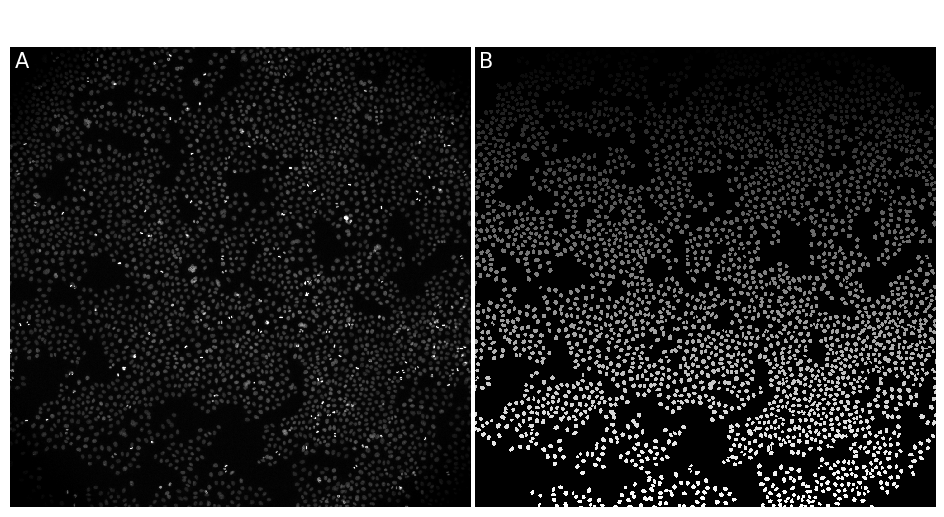

In [14]:
panel = Micropanel(rows=1, cols=2, figscaling=5)
panel.add_element([0,0], dapi_microshow);
panel.add_element([0,1], nuclei_microshow);
panel.add_channel_label()

In [15]:
# segment cells using nuclei, cell area threshold
cells = Snake._segment_cells(data[0], nuclei, THRESHOLD_CELL)
# save(name(description, tag='cells'), cells, compress=1)

Number of cells segmented: 3251


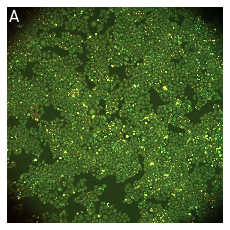

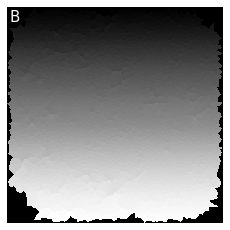

In [16]:
# Create microshow plots for each channel with specified colormaps and display ranges
all_microshow = microplot.microshow(aligned[0, :, :, :],
                                     label_text='A',
                                     rescale_type='limits', 
                                     limits=DISPLAY_RANGES[0],
                                     channel_names='Merged')

cells_microshow = microplot.microshow(cells, 
                                       label_text='B',
                                       channel_names='Cells')

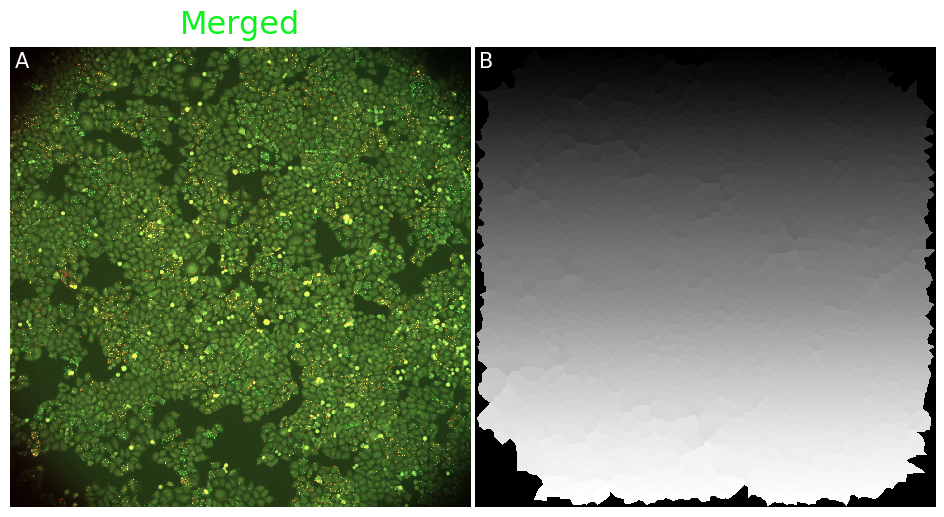

In [17]:
panel = Micropanel(rows=1, cols=2, figscaling=5)
panel.add_element([0,0], all_microshow);
panel.add_element([0,1], cells_microshow);
panel.add_channel_label()

##### extract base intensity, call reads, assign to cells

In [18]:
# extract bases using maxed filters, peaks, cells, read thresholds specified, and base order
df_bases = Snake._extract_bases(maxed, peaks, cells, THRESHOLD_READS, wildcards=WILDCARDS, bases=BASES)
# df_bases.to_csv(name(description, tag='bases', ext='csv'), index=None)
df_bases.head()

read  cycle channel  intensity  cell  i    j  tile well
0     0      1       A        651     0  5  222    50   A1
1     0      1       C       2225     0  5  222    50   A1
2     0      1       G         13     0  5  222    50   A1
3     0      1       T         15     0  5  222    50   A1
4     0      2       A        960     0  5  222    50   A1

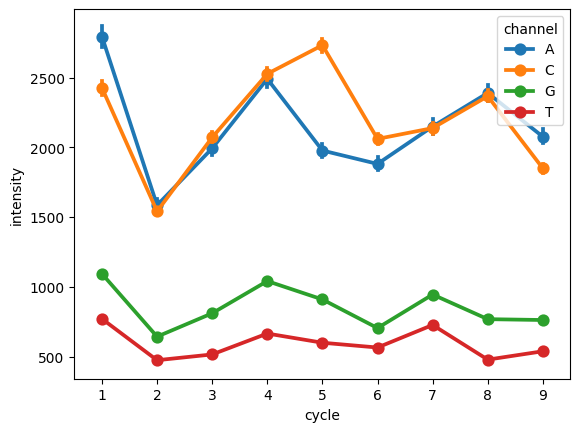

In [19]:
ax = sns.pointplot(x="cycle", y="intensity", hue="channel", data=df_bases)
plt.show()

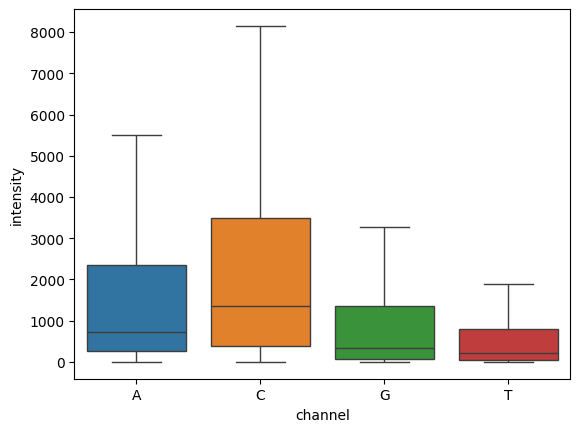

In [20]:
ax = sns.boxplot(x="channel", y="intensity", hue="channel", data=df_bases, showfliers=False)
plt.show()

In [43]:
# extract reads using bases, peaks
df_reads = Snake._call_reads(df_bases, peaks=peaks, subtract_channel_min=True)
# df_reads.to_csv(name(description, tag='reads', ext='csv'), index=None)
df_reads.head()

read  cell  i     j  tile well    barcode       Q_0       Q_1       Q_2  \
0       0     0  5   222    50   A1  CATTGCACG  1.000000  0.604820  1.000000   
36      1     0  5   556    50   A1  TGCTGAATT  1.000000  0.783859  0.952057   
72      2     0  5   756    50   A1  AGCAGAACC  0.535843  0.193379  1.000000   
108     3     0  5   929    50   A1  CATTGCACG  1.000000  0.712938  0.432937   
144     4     0  5  1137    50   A1  CGTGTTCCC  1.000000  0.270708  0.914519   

          Q_3       Q_4       Q_5       Q_6      Q_7       Q_8     Q_min  \
0    0.870735  1.000000  0.954320  1.000000  1.00000  0.886431  0.604820   
36   0.535095  0.368296  0.804310  0.586058  0.59982  1.000000  0.368296   
72   0.965781  0.988966  1.000000  0.506107  0.87041  0.946275  0.193379   
108  0.995725  1.000000  1.000000  0.960422  1.00000  0.992171  0.432937   
144  0.784381  1.000000  0.979668  0.955037  1.00000  0.692747  0.270708   

            peak  
0     582.800897  
36    544.671125  
72    494.207314  
108  1802.625189  
144   890.176558

In [47]:
# extract cells with reads using reads
df_cells = Snake._call_cells(df_reads, df_pool=df_pool, q_min=Q_MIN)
# df_cells.to_csv(name(description, tag='cells', ext='csv'), index=None)
df_cells.head()

cell  tile well       Q_0       Q_1       Q_2       Q_3       Q_4  \
0    27    50   A1  1.000000  0.714510  0.900731  1.000000  1.000000   
1    31    50   A1  0.753622  0.266207  1.000000  0.453992  0.896924   
2    33    50   A1  1.000000  1.000000  1.000000  0.982175  0.390964   
3    38    50   A1  0.984514  0.571407  0.831175  1.000000  0.467758   
4    41    50   A1  1.000000  1.000000  0.846556  1.000000  0.408369   

        Q_5       Q_6  ...  cell_barcode_count_0  cell_barcode_1  \
0  0.917026  1.000000  ...                     4       ATCCCCCCC   
1  1.000000  1.000000  ...                     3             NaN   
2  0.988945  0.459834  ...                    10       CACCTGAAT   
3  0.682396  0.632393  ...                     1             NaN   
4  0.392253  0.585665  ...                     4       GTACACCCA   

   cell_barcode_count_1  barcode_count               sgRNA_0  gene_symbol_0  \
0                   1.0              5                   NaN            NaN   
1                   0.0              3  TGCTGAATTGCATGTCCTTG           CDC6   
2                   1.0             12  CAGCACGGATGATACCATCG           UBL5   
3                   0.0              1  TTGTAGAGAAGATGGTGGGT         TOMM20   
4                   1.0              5                   NaN            NaN   

  gene_id_0  sgRNA_1  gene_symbol_1 gene_id_1  
0       NaN      NaN            NaN       NaN  
1      CDC6      NaN            NaN       NaN  
2      UBL5      NaN            NaN       NaN  
3    TOMM20      NaN            NaN       NaN  
4       NaN      NaN            NaN       NaN  

[5 rows x 25 columns]

In [48]:
# extract minimal phenotype information from nuclei
df_sbs_info = Snake._extract_phenotype_minimal(data_phenotype=nuclei, nuclei = nuclei, wildcards=WILDCARDS)
# df_sbs_info.to_csv(name(description, tag='sbs_info', ext='csv'), index=None)
df_sbs_info.head()

area         i           j  cell             bounds  tile well
0    49  1.693878  282.979592     1   (0, 278, 6, 291)    50   A1
1    75  2.760000  480.480000     2   (0, 475, 8, 487)    50   A1
2   107  4.130841  589.000000     3  (0, 583, 10, 596)    50   A1
3   117  3.905983  715.384615     4  (0, 708, 10, 723)    50   A1
4   102  3.617647  847.813725     5   (0, 841, 9, 855)    50   A1

### Visualize sbs output from collated information across all wells

In [24]:
# bases = pd.read_csv('A1_bases.csv')

In [25]:
# ax = sns.pointplot(x="cycle", y="intensity", hue="channel", data=bases)
# plt.show()

In [26]:
# ax = sns.boxplot(x="channel", y="intensity", hue="channel", data=bases, showfliers=False)
# plt.show()

In [34]:
cells = pd.read_hdf('cells.hdf')

In [35]:
sbs_info = pd.read_hdf('sbs_info.hdf')

In [61]:
num_rows = len(sbs_info)
print(f"The number of cells extracted in the sbs step is: {num_rows}")

The number of cells extracted in the sbs step is: 7996757


In [38]:
reads = pd.read_hdf('reads.hdf')

In [41]:
# number of sequencing reads, percent matching barcode

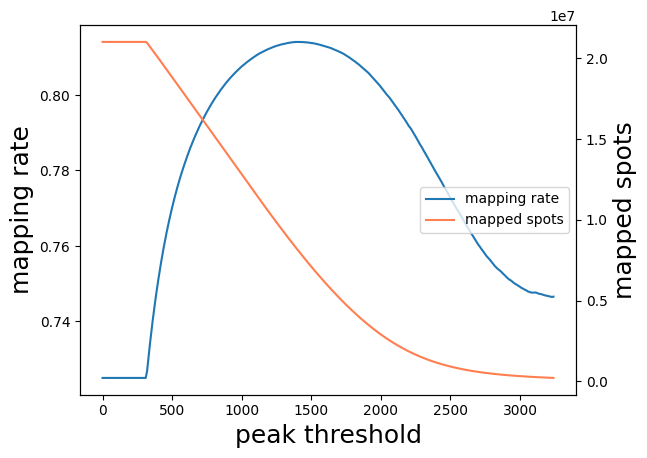

In [55]:
mapping_vs_threshold = plot_mapping_vs_threshold(reads, barcodes)

(array([[<Axes: title={'center': 'Well A1'}>,
         <Axes: title={'center': 'Well A2'}>,
         <Axes: title={'center': 'Well A3'}>],
        [<Axes: title={'center': 'Well B1'}>,
         <Axes: title={'center': 'Well B2'}>,
         <Axes: title={'center': 'Well B3'}>]], dtype=object),
 <matplotlib.colorbar.Colorbar at 0x7f99fd70e400>)

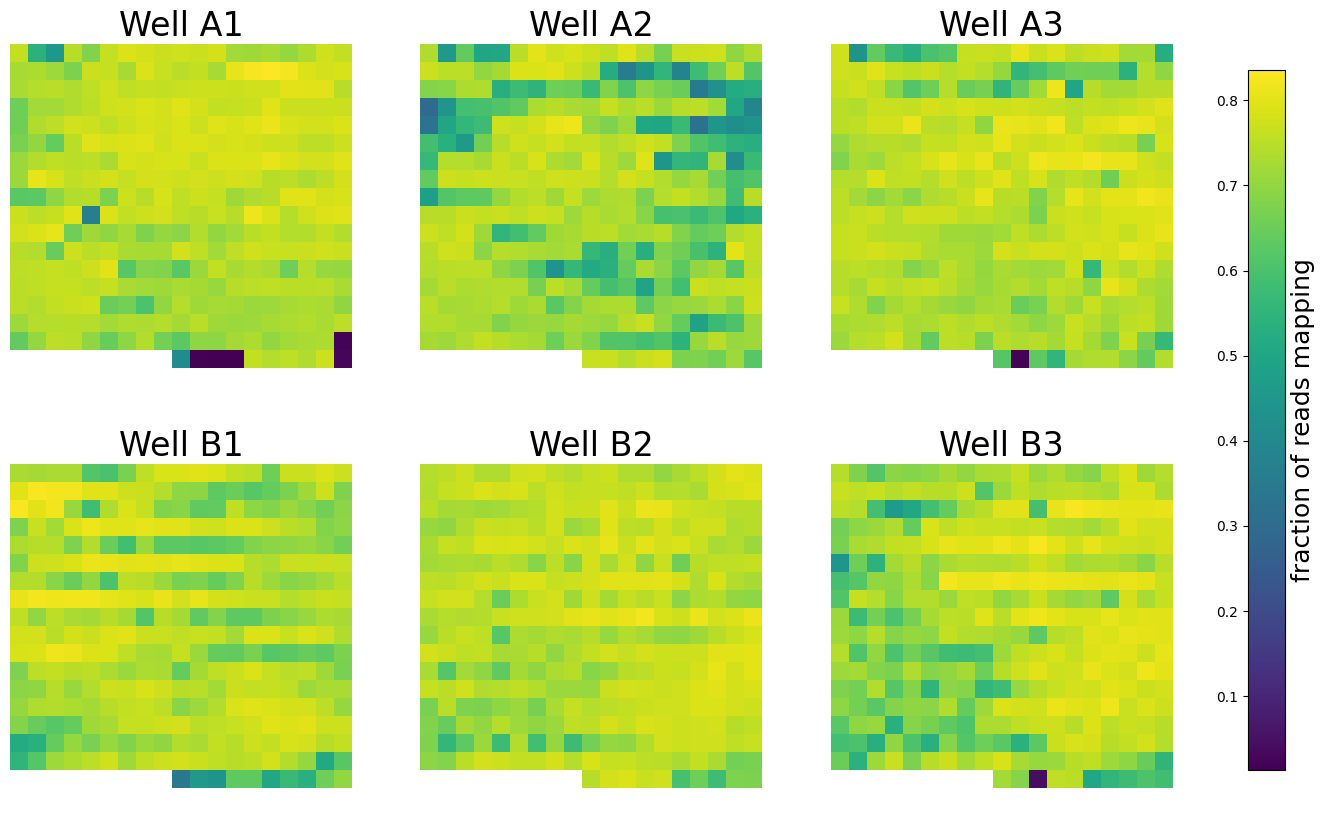

In [40]:
plot_read_mapping_heatmap(reads, barcodes)

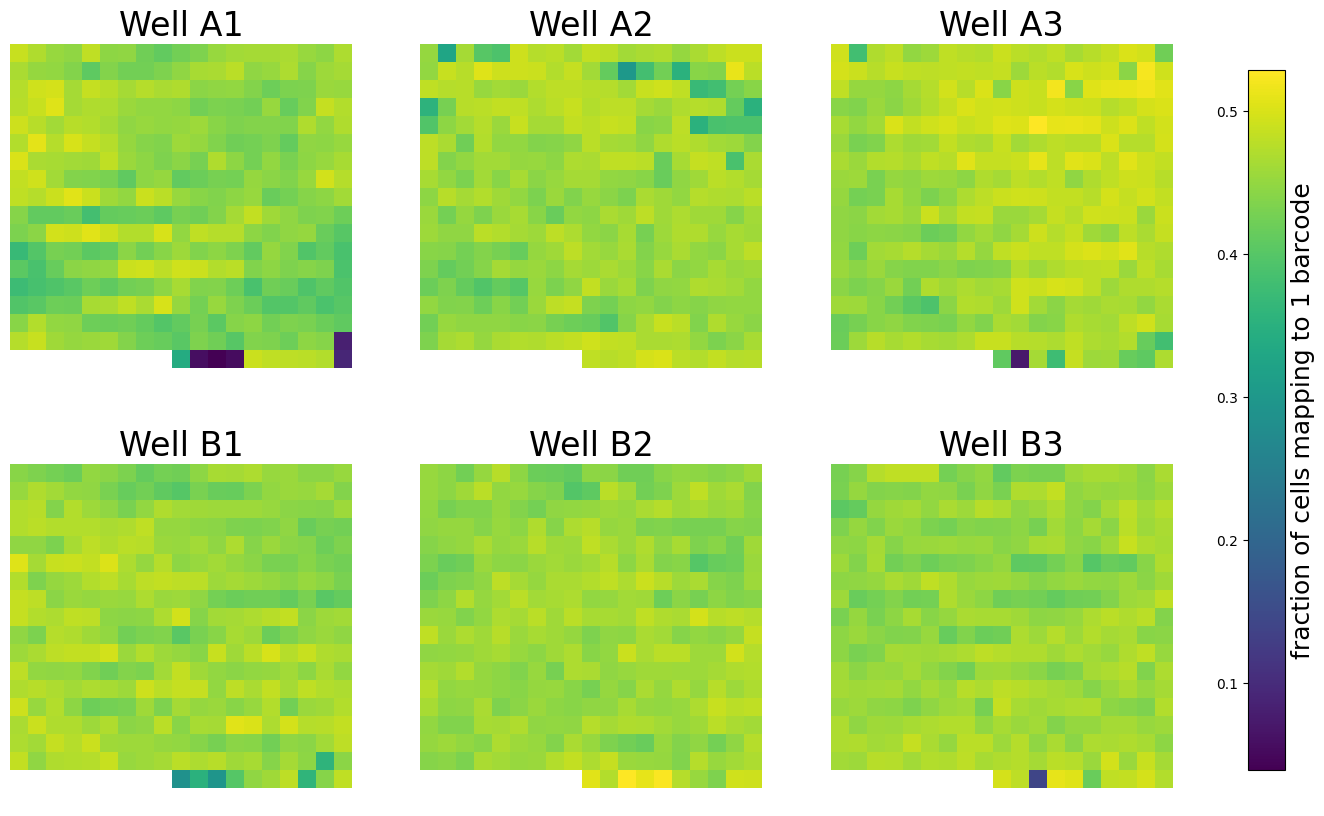

In [53]:
cell_mapping_gene_symbols = plot_cell_mapping_heatmap(cells, sbs_info, barcodes, mapping_strategy = 'gene_symbols')

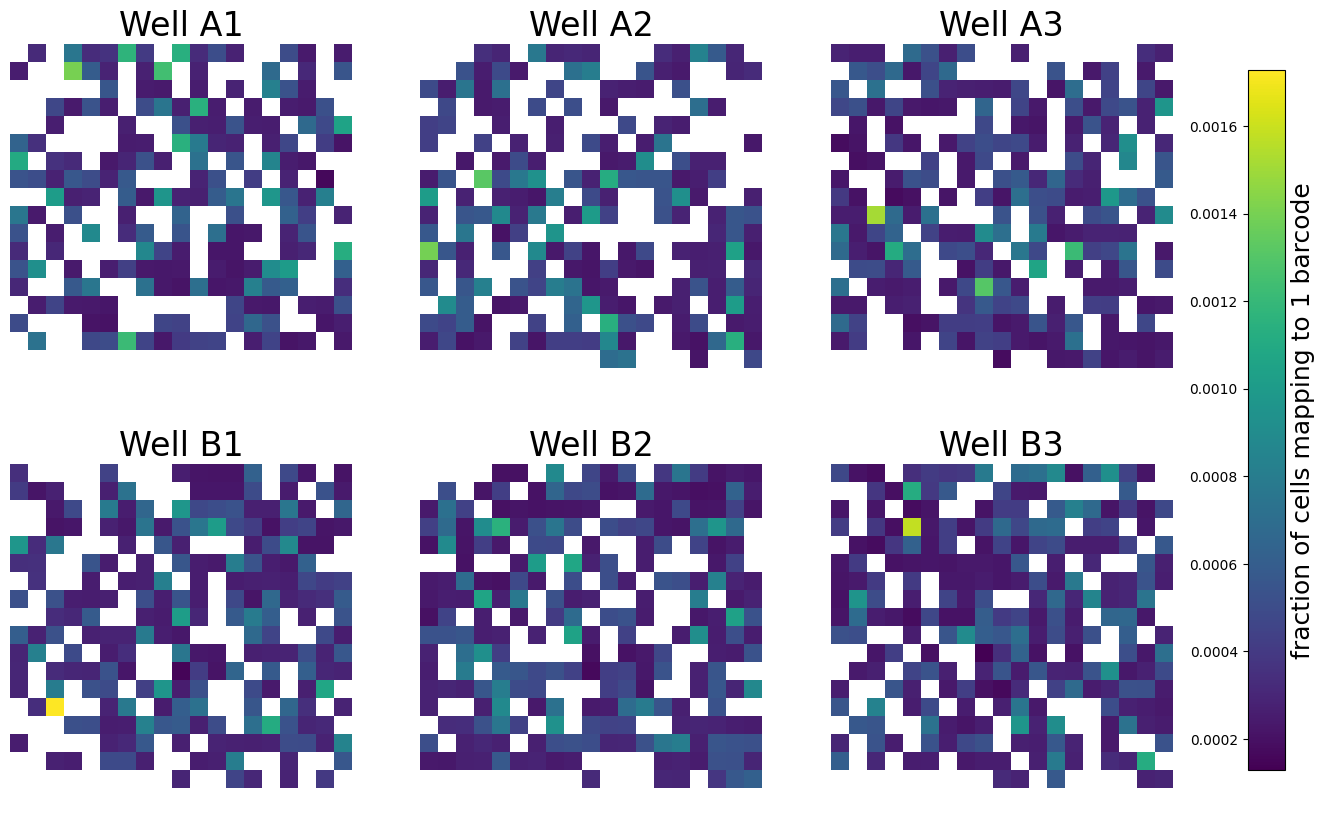

In [54]:
cell_mapping_gene_symbols = plot_cell_mapping_heatmap(cells, sbs_info, barcodes, mapping_strategy = 'barcodes')

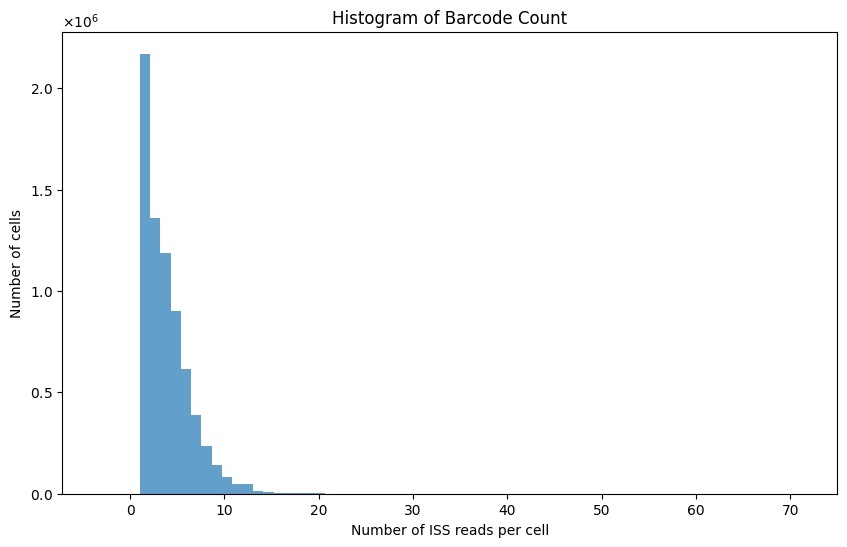

1000    103
1040    122
1485    122
1510    122
288      76
590      93
706      87
781     165
793     117
Name: barcode_count, dtype: int64

In [88]:
plot_barcode_count_histogram(cells, x_cutoff = 75)

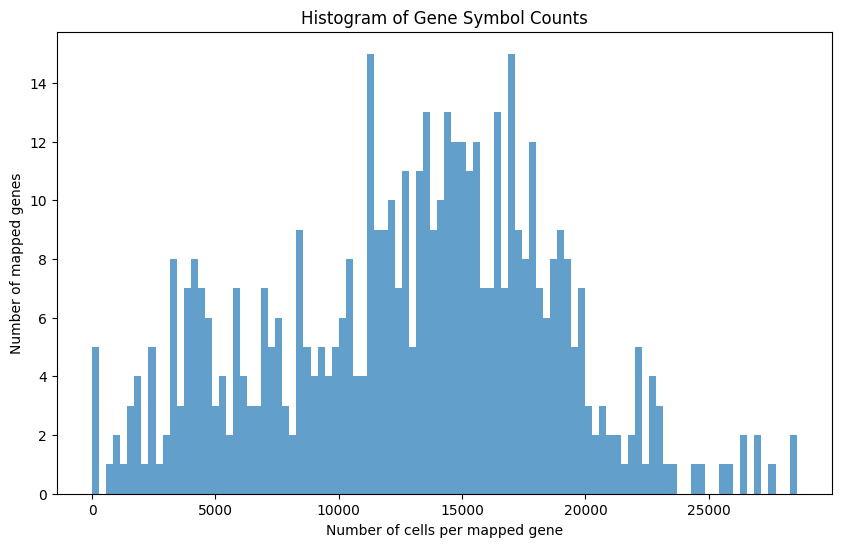

In [89]:
plot_gene_symbol_histogram(cells)